In [1]:
from torch import nn
from tqdm import tqdm
import torch.nn.functional as F
from torchvision import datasets, models

In [2]:
import torch
from torchvision import datasets, transforms
# import helper

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# # Download and load the test data
# testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
import numpy as np

In [4]:
classes = np.unique(trainset.targets.numpy())
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [5]:
# Creating Mapping for source and payload images

mapping = {key: key + 1 for key in np.arange(0, len(classes), 2)}
mapping

{0: 1, 2: 3, 4: 5, 6: 7, 8: 9}

In [6]:
# Converting tensors to numpy

train_x = trainset.data.numpy()
train_y = trainset.targets.numpy()

In [7]:
# Creating source and payload masks from labels

source_mask = np.in1d(train_y, list(mapping.keys()))
payload_mask = np.logical_not(source_mask)

print(np.sum(source_mask), np.sum(payload_mask))

# Creating source and payload data
source_data, source_labels = train_x[source_mask], train_y[source_mask]
payload_data, payload_labels = train_x[payload_mask], train_y[payload_mask]

30000 30000


In [8]:
np.unique(train_y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

# Visualizing Data

In [9]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


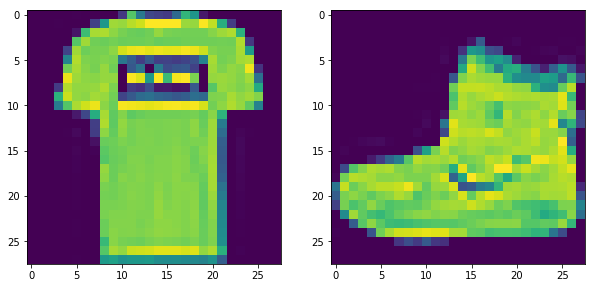

In [10]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(source_data[0])
plt.subplot(1,2,2)
plt.imshow(payload_data[0])

# Train Val Test splitting

In [11]:
split_size = 0.8

total_data = source_data.shape[0]

train_size = int(total_data * split_size)
source_train = source_data[:train_size] # , source_labels[:train_size]
payload_train = payload_data[:train_size] # , payload_labels[:train_size]

remaining_source, remaining_payload = source_data[train_size:], payload_data[train_size:]
half_size = int(remaining_source.shape[0] / 2.)

source_val, payload_val = remaining_source[:half_size], remaining_payload[:half_size]
source_test, payload_test = remaining_source[half_size:], remaining_payload[half_size:]

print(source_train.shape, source_val.shape, source_test.shape)
print(payload_train.shape, payload_val.shape, payload_test.shape)

(24000, 28, 28) (3000, 28, 28) (3000, 28, 28)
(24000, 28, 28) (3000, 28, 28) (3000, 28, 28)


# Declaring Architecture

In [12]:
class StegNet(nn.Module):
    def __init__(self):
        super(StegNet, self).__init__()
        self.encoder_source, self.encoder_payload = self.define_encoder()
        self.decoder = self.define_decoder()
        
    def define_encoder(self):
        encoder_payload, encoder_source = [], []
        
        # layer1
        self.encoder_payload_1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.encoder_source_1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        
        # layer2
        self.encoder_payload_2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.encoder_source_2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        
        # layer3
        self.encoder_payload_3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.encoder_source_3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        
        # layer4
        self.encoder_payload_4 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.encoder_source_4 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        
        # layer5
        self.encoder_payload_5 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.encoder_source_5 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        
        # layer6
        self.encoder_payload_6 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.encoder_source_6 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        
        # layer7
        self.encoder_payload_7 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.encoder_source_7 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        
        # layer8
        self.encoder_payload_8 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.encoder_source_8 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        
        # layer9
        self.encoder_source_9 = nn.Conv2d(16, 16, kernel_size=1)
        
        #layer10
        self.encoder_source_10 = nn.Conv2d(16, 8, kernel_size=1)
        
        #layer11
        self.encoder_source_11 = nn.Conv2d(8, 1, kernel_size=1)
        
        return encoder_source,  encoder_payload
    
    def define_decoder(self):
        decoder_layers = []
        
        self.decoder_layers1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.decoder_layers2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        
        self.decoder_layers3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.decoder_layers4 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        
        self.decoder_layers5 = nn.Conv2d(8, 3, kernel_size=3, padding=1)
        self.decoder_layers6 = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        
        self.decoder_layers7 = nn.Conv2d(3, 1, kernel_size=3, padding=1)
        
        return decoder_layers
    
    def forward(self, x):
        
        source, payload = x
        
        s = source.view((-1, 1, 28, 28))
        p = payload.view((-1, 1, 28, 28))
        
        # --------------------------- Encoder -------------------------
        # layer1
        p = F.relu(self.encoder_payload_1(p))
        s = F.relu(self.encoder_source_1(s))
        
        #layer2
        p = F.relu(self.encoder_payload_2(p))
        s = torch.cat((s, p), 1)
        s = F.relu(self.encoder_source_2(s))
        # layer3
        p = F.relu(self.encoder_payload_3(p))
        s = F.relu(self.encoder_source_3(s))
        
        #layer4
        p = F.relu(self.encoder_payload_4(p))
        s = torch.cat((s, p), 1)
        s = F.relu(self.encoder_source_4(s))
        
        # layer5
        p = F.relu(self.encoder_payload_5(p))
        s = F.relu(self.encoder_source_5(s))
        
        #layer6
        p = F.relu(self.encoder_payload_6(p))
        s = torch.cat((s, p), 1)
        s = F.relu(self.encoder_source_6(s))
        
        # layer7
        p = F.relu(self.encoder_payload_7(p))
        s = F.relu(self.encoder_source_7(s))
        
        #layer8
        p = F.relu(self.encoder_payload_8(p))
        s = torch.cat((s, p), 1)
        s = F.relu(self.encoder_source_8(s))
        
        #layer9
        s = F.relu(self.encoder_source_9(s))
        
        #layer10
        s = F.relu(self.encoder_source_10(s))
        
        #layer11
        encoder_output = self.encoder_source_11(s)
        
        # -------------------- Decoder --------------------------
        
        d = encoder_output.view(-1, 1, 28, 28)
        
        #layer1
        d = F.relu(self.decoder_layers1(d))
        #layer2
        d = F.relu(self.decoder_layers2(d))
        #layer3
        d = F.relu(self.decoder_layers3(d))
        #layer4
        d = F.relu(self.decoder_layers4(d))
        #layer5
        d = F.relu(self.decoder_layers5(d))
        #layer6
        d = F.relu(self.decoder_layers6(d))        
        #layer7
        decoder_output = self.decoder_layers7(d)
        
        return encoder_output, decoder_output
    
model = StegNet()
model

StegNet(
  (encoder_payload_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_6

In [13]:
model.cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

metric = nn.L1Loss()

In [41]:
epochs = 30

train_losses, val_losses = [], []
batch_size = 64

for epoch in range(epochs):
    model.train()
    train_loss = 0.
    total_batches = int(len(source_train) /batch_size)
    for idx in tqdm(range(total_batches)):
        
        s, p = source_train[idx*batch_size: (idx * batch_size) + batch_size], payload_train[idx*batch_size: (idx * batch_size) + batch_size]
        s, p = torch.from_numpy(s).unsqueeze(1).float().cuda(), torch.from_numpy(p).unsqueeze(1).float().cuda()
        
        optimizer.zero_grad()
        
        e_out, d_out = model.forward((s, p))
        
        e_loss = criterion(e_out.squeeze(1).view((-1, 28 * 28)), s.squeeze(1).view((-1, 28 * 28)))
        d_loss = criterion(d_out.squeeze(1).view((-1, 28 * 28)), p.squeeze(1).view((-1, 28 * 28)))
        loss = e_loss + d_loss
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    else:
        val_loss = 0.
        model.eval()
        with torch.no_grad():
            for idx in tqdm(range(int(len(source_val) / 60))):
                s, p = source_val[idx*60: (idx * 60) + 60], payload_val[idx*60: (idx * 60) + 60]
                s, p = torch.from_numpy(s).unsqueeze(1).float().cuda(), torch.from_numpy(p).unsqueeze(1).float().cuda()
                
                e_out, d_out = model.forward((s, p))
        
                e_loss = metric(e_out.squeeze(1).view((-1, 28 * 28)), s.squeeze(1).view((-1, 28 * 28)))
                d_loss = metric(d_out.squeeze(1).view((-1, 28 * 28)), p.squeeze(1).view((-1, 28 * 28)))
                loss = e_loss + d_loss
                
                val_loss += loss
            
            train_losses.append(train_loss / total_batches)
            val_losses.append(val_loss / int(len(source_val) / 60))
            
            print('Epoch: {}\nTrain Loss: {}, Val Loss: {}'.format(epoch, train_losses[-1], val_losses[-1]))
                
                
                

  2%|▏         | 7/375 [00:00<00:05, 66.80it/s]

Epoch: 0
Train Loss: 438.6692014973958, Val Loss: 16.76128578186035


  2%|▏         | 7/375 [00:00<00:05, 66.39it/s]

Epoch: 1
Train Loss: 429.8233525390625, Val Loss: 16.36132049560547


  2%|▏         | 7/375 [00:00<00:05, 66.59it/s]

Epoch: 2
Train Loss: 431.56418204752606, Val Loss: 16.507417678833008


  2%|▏         | 7/375 [00:00<00:05, 66.65it/s]

Epoch: 3
Train Loss: 417.80074096679687, Val Loss: 15.754133224487305


  2%|▏         | 7/375 [00:00<00:05, 66.88it/s]

Epoch: 4
Train Loss: 427.6876896158854, Val Loss: 17.656484603881836


  2%|▏         | 7/375 [00:00<00:05, 65.88it/s]

Epoch: 5
Train Loss: 411.8878956705729, Val Loss: 15.62134838104248


  2%|▏         | 7/375 [00:00<00:05, 67.05it/s]

Epoch: 6
Train Loss: 407.66591153971353, Val Loss: 15.692747116088867


  2%|▏         | 7/375 [00:00<00:05, 66.54it/s]

Epoch: 7
Train Loss: 411.22719864908856, Val Loss: 15.327337265014648


  2%|▏         | 7/375 [00:00<00:05, 67.53it/s]

Epoch: 8
Train Loss: 450.87426049804685, Val Loss: 15.52304744720459


  2%|▏         | 7/375 [00:00<00:05, 65.44it/s]

Epoch: 9
Train Loss: 394.7574444986979, Val Loss: 15.224921226501465


  2%|▏         | 7/375 [00:00<00:05, 66.49it/s]

Epoch: 10
Train Loss: 412.3333410644531, Val Loss: 15.425021171569824


  2%|▏         | 7/375 [00:00<00:05, 66.74it/s]

Epoch: 11
Train Loss: 404.9670356445312, Val Loss: 15.492266654968262


  2%|▏         | 7/375 [00:00<00:05, 67.87it/s]

Epoch: 12
Train Loss: 390.4367500813802, Val Loss: 15.78767204284668


  2%|▏         | 7/375 [00:00<00:05, 65.98it/s]

Epoch: 13
Train Loss: 411.292244140625, Val Loss: 15.540261268615723


  2%|▏         | 7/375 [00:00<00:05, 66.96it/s]

Epoch: 14
Train Loss: 399.8577830403646, Val Loss: 15.405801773071289


  2%|▏         | 7/375 [00:00<00:05, 66.19it/s]

Epoch: 15
Train Loss: 406.39305224609376, Val Loss: 15.564441680908203


  2%|▏         | 7/375 [00:00<00:05, 67.41it/s]

Epoch: 16
Train Loss: 380.45378409830727, Val Loss: 15.640108108520508


  2%|▏         | 7/375 [00:00<00:06, 59.92it/s]

Epoch: 17
Train Loss: 382.2309629720052, Val Loss: 16.272886276245117


  2%|▏         | 7/375 [00:00<00:05, 65.96it/s]

Epoch: 18
Train Loss: 387.6593831380208, Val Loss: 15.548934936523438


  2%|▏         | 7/375 [00:00<00:05, 66.01it/s]

Epoch: 19
Train Loss: 406.27087337239584, Val Loss: 15.028783798217773


  2%|▏         | 7/375 [00:00<00:05, 65.79it/s]

Epoch: 20
Train Loss: 376.78302083333335, Val Loss: 15.333130836486816


  2%|▏         | 7/375 [00:00<00:05, 66.90it/s]

Epoch: 21
Train Loss: 385.18661824544273, Val Loss: 14.972023963928223


  2%|▏         | 7/375 [00:00<00:05, 66.48it/s]

Epoch: 22
Train Loss: 377.27966910807294, Val Loss: 15.109006881713867


  2%|▏         | 7/375 [00:00<00:05, 66.91it/s]

Epoch: 23
Train Loss: 382.07636726888023, Val Loss: 14.940469741821289


  2%|▏         | 7/375 [00:00<00:05, 66.88it/s]

Epoch: 24
Train Loss: 385.5144608561198, Val Loss: 15.684576988220215


  2%|▏         | 7/375 [00:00<00:05, 65.60it/s]

Epoch: 25
Train Loss: 399.22506095377605, Val Loss: 14.898377418518066


  2%|▏         | 7/375 [00:00<00:05, 66.06it/s]

Epoch: 26
Train Loss: 373.49682096354167, Val Loss: 14.597481727600098


  2%|▏         | 7/375 [00:00<00:05, 66.00it/s]

Epoch: 27
Train Loss: 370.98183878580727, Val Loss: 16.146440505981445


  2%|▏         | 7/375 [00:00<00:05, 67.00it/s]

Epoch: 28
Train Loss: 404.4077938639323, Val Loss: 14.67546272277832


100%|██████████| 50/50 [00:00<00:00, 336.93it/s]

Epoch: 29
Train Loss: 378.5537091471354, Val Loss: 15.20047664642334


In [42]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/rameez/.conda/envs/pytorch/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [43]:
with torch.no_grad():
    model.eval()
    e, d = model.forward((s, p))

In [44]:
e, d = e.cpu(), d.cpu()
ss, pp = s.cpu(), p.cpu()

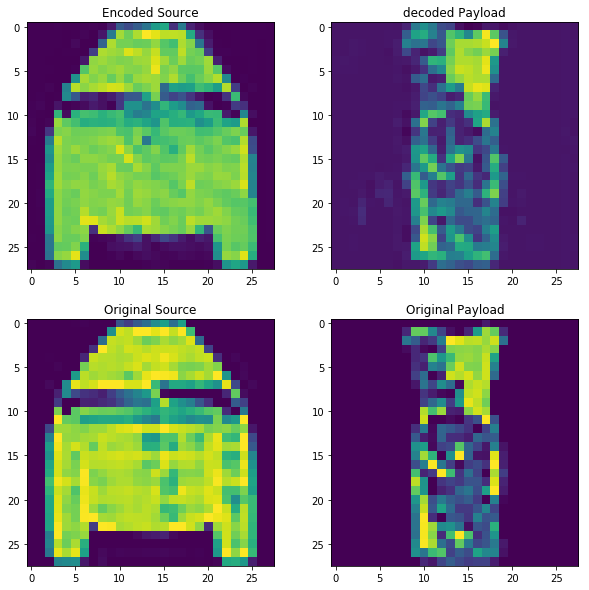

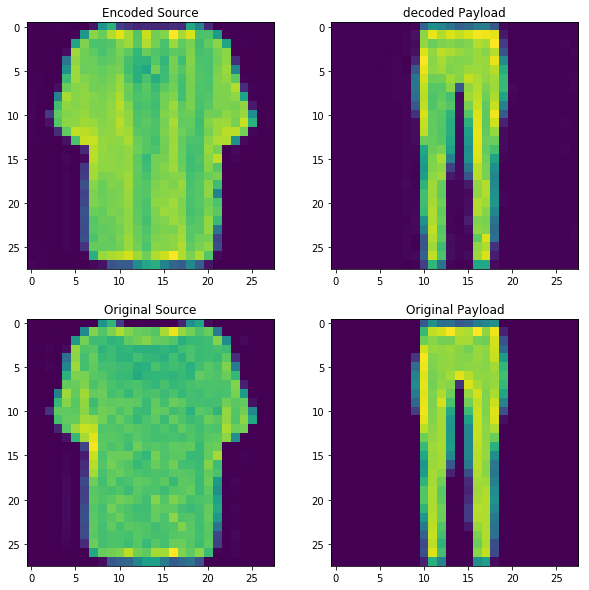

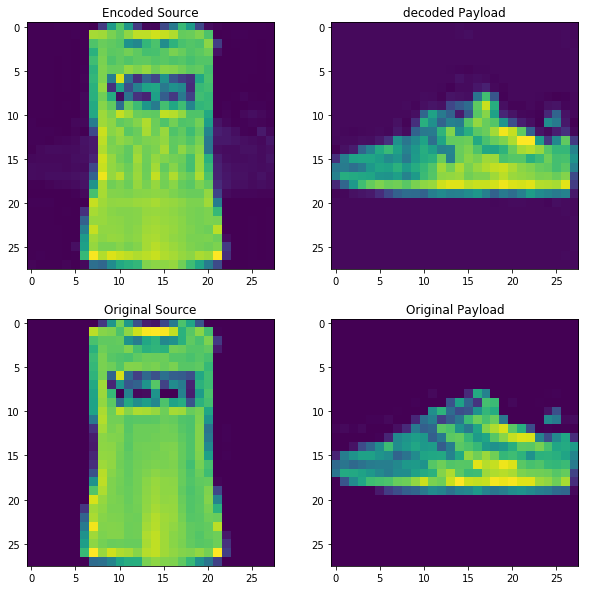

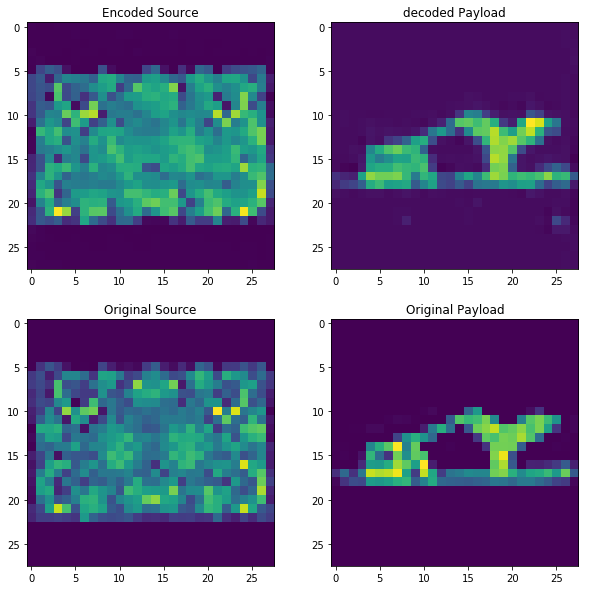

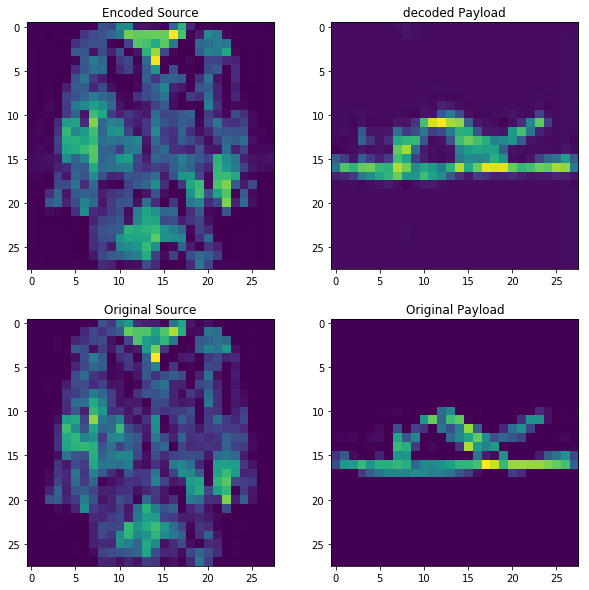

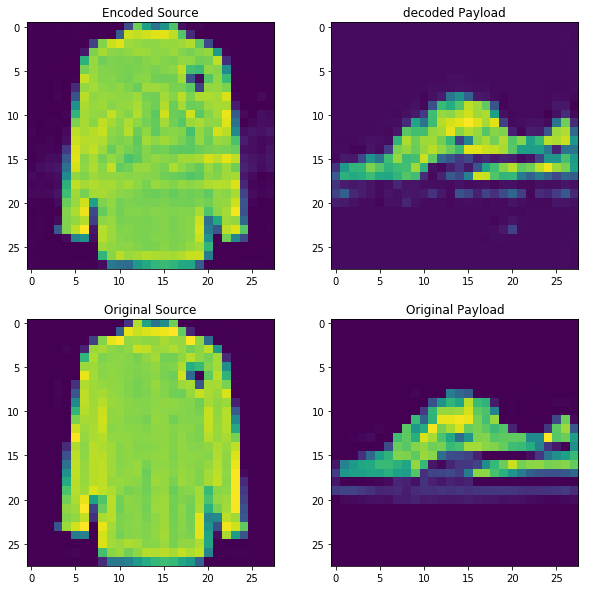

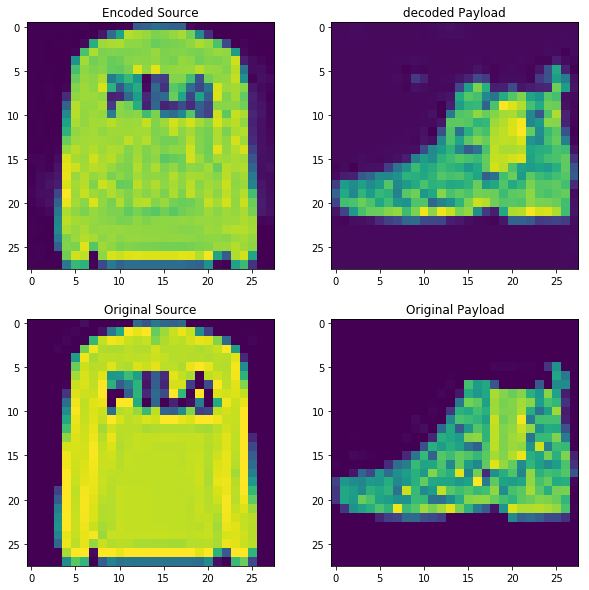

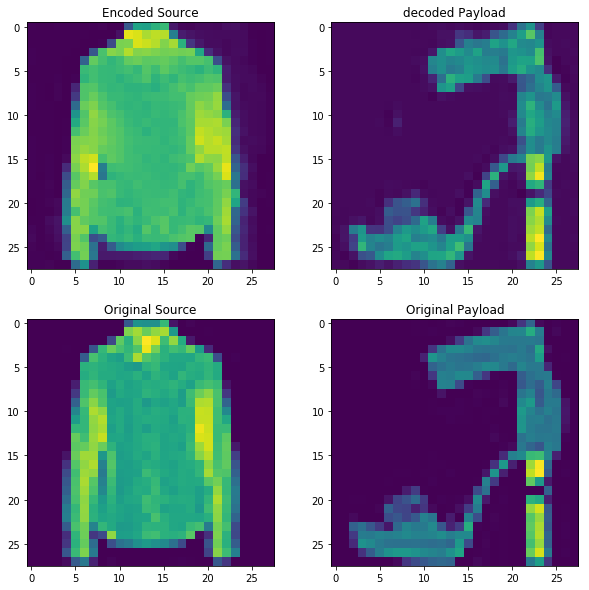

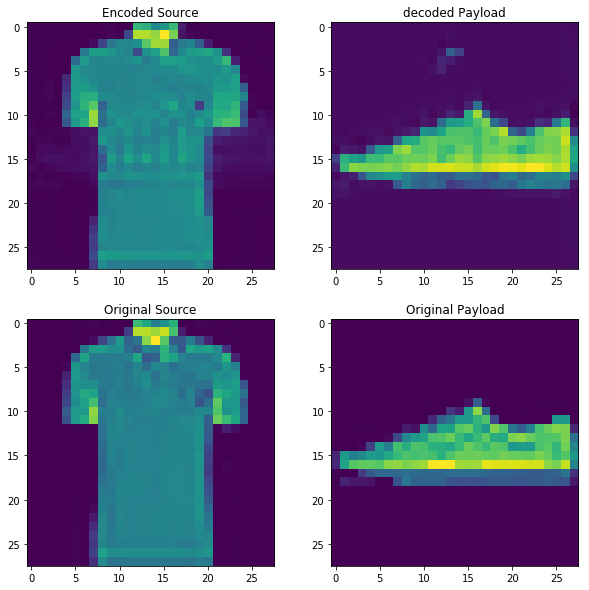

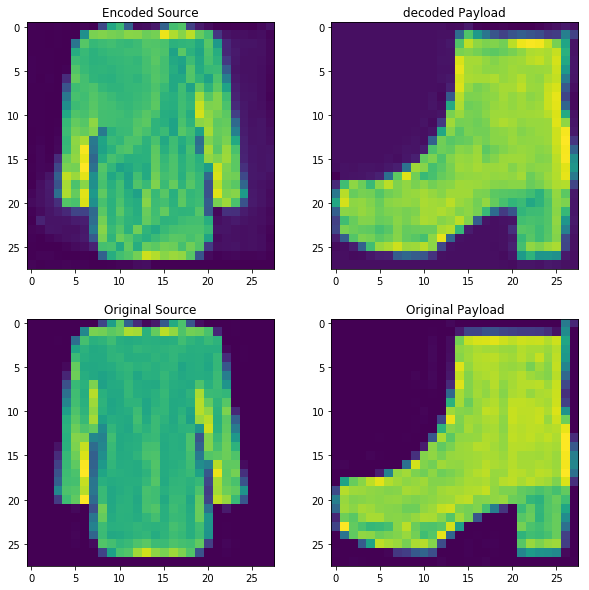

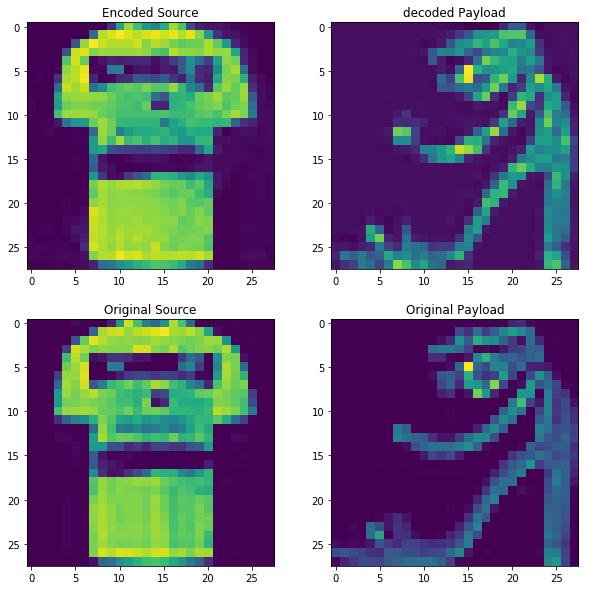

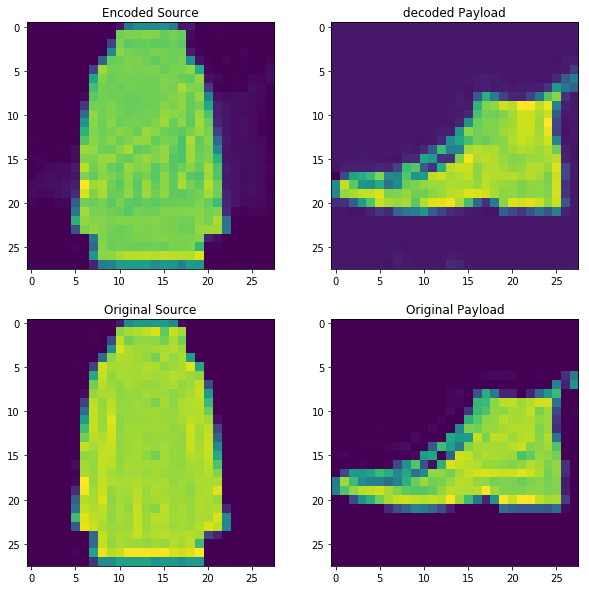

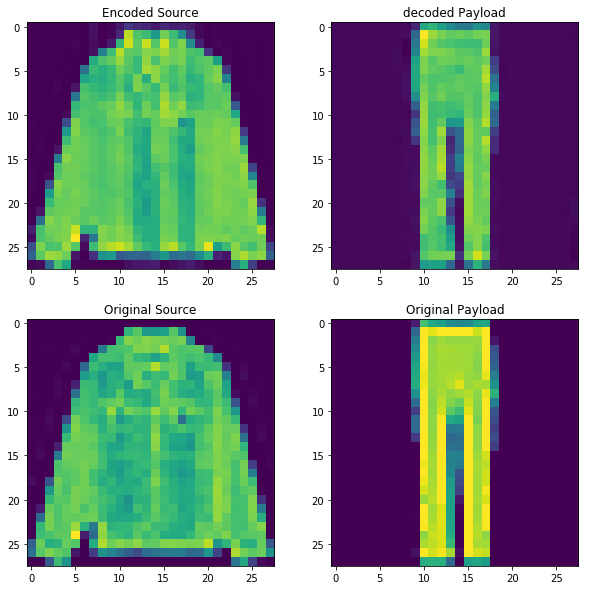

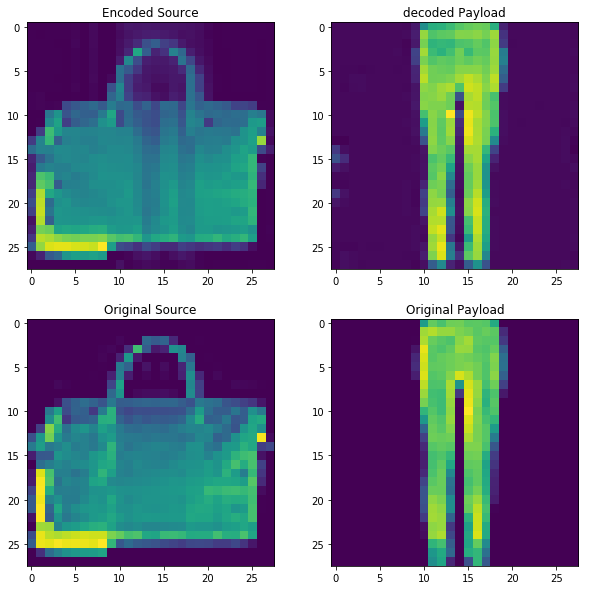

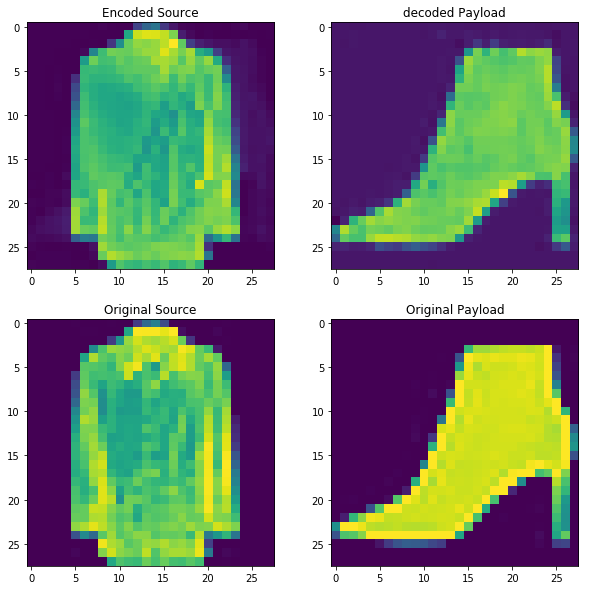

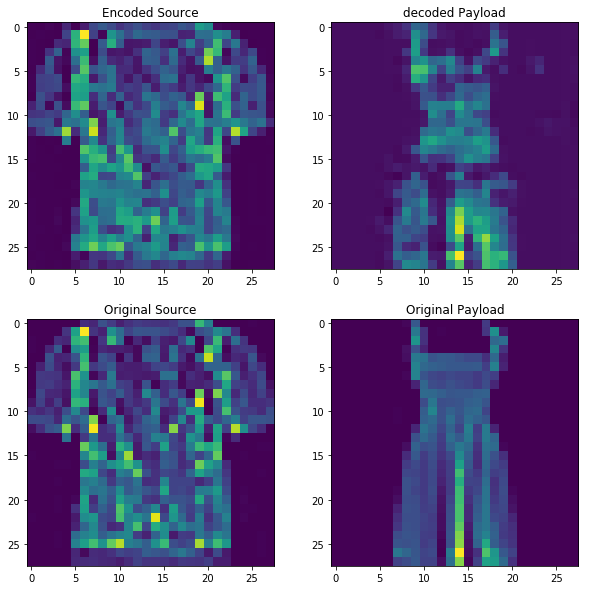

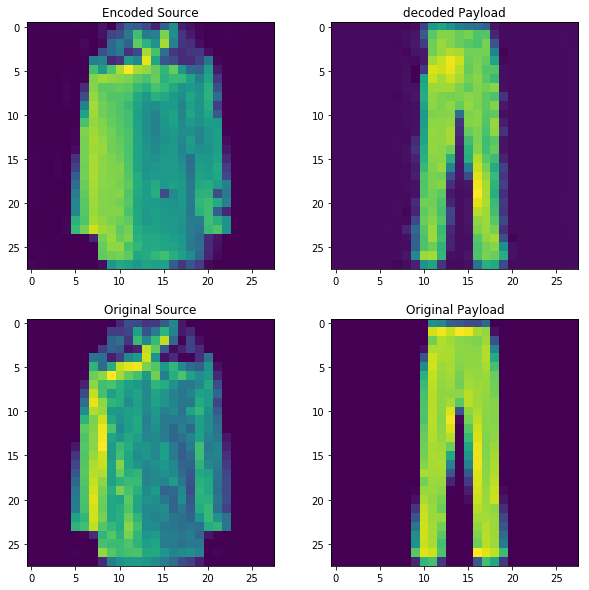

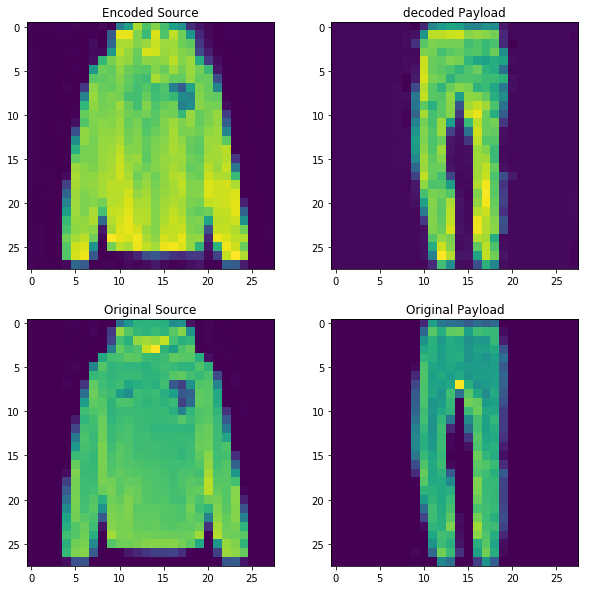

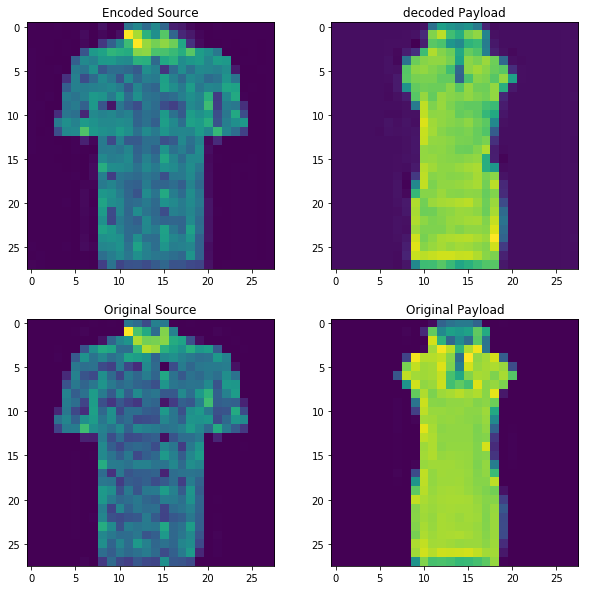

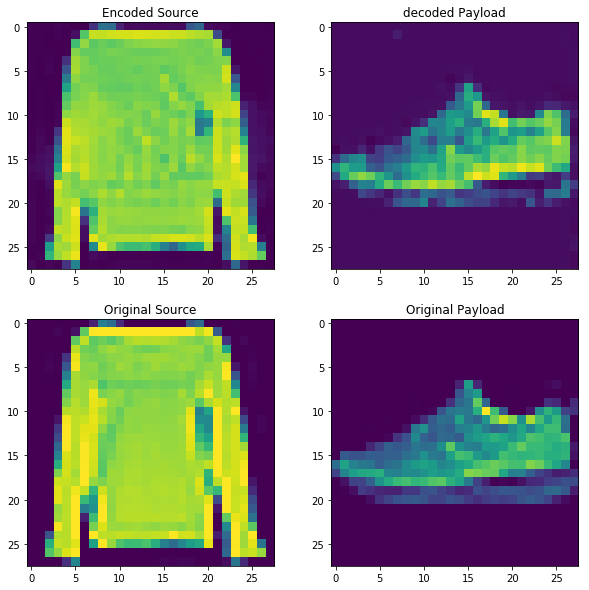

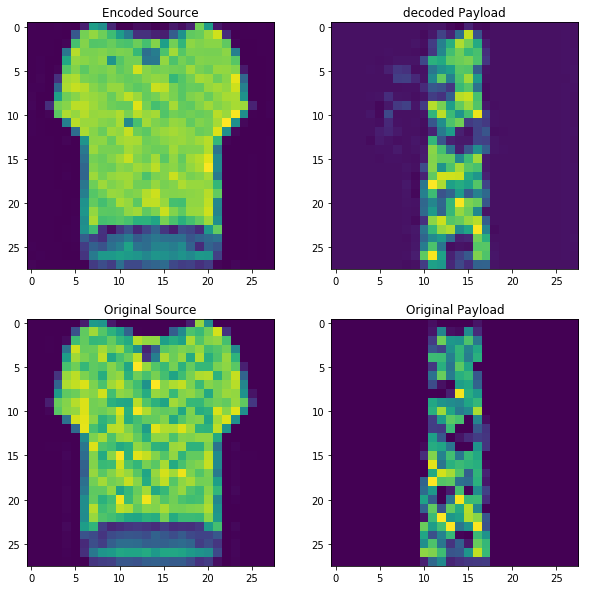

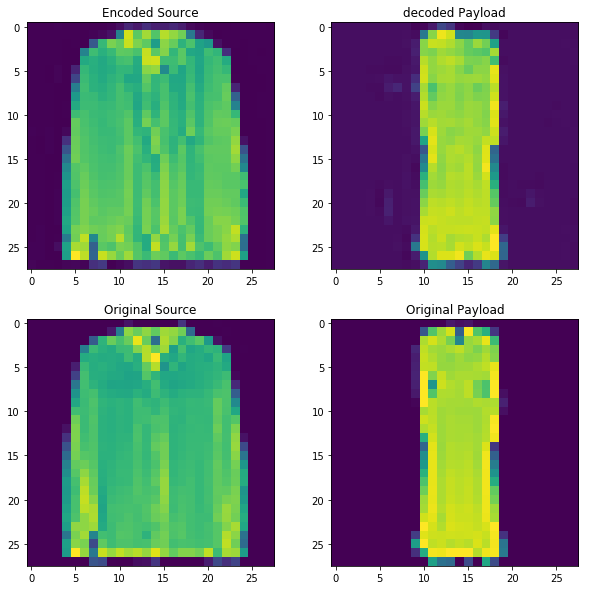

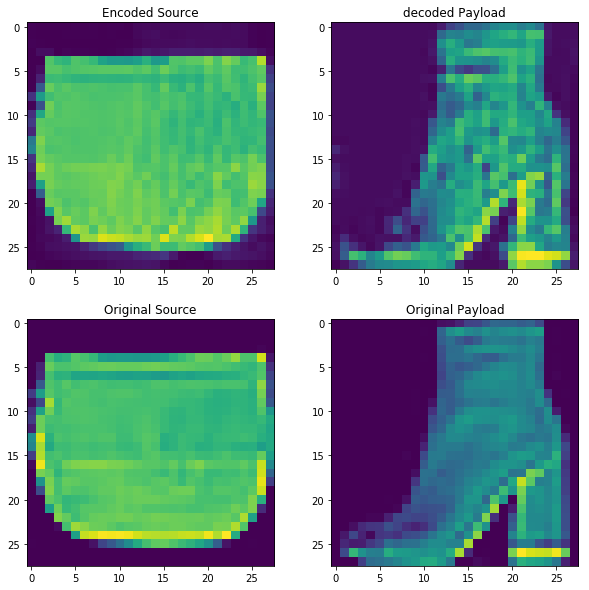

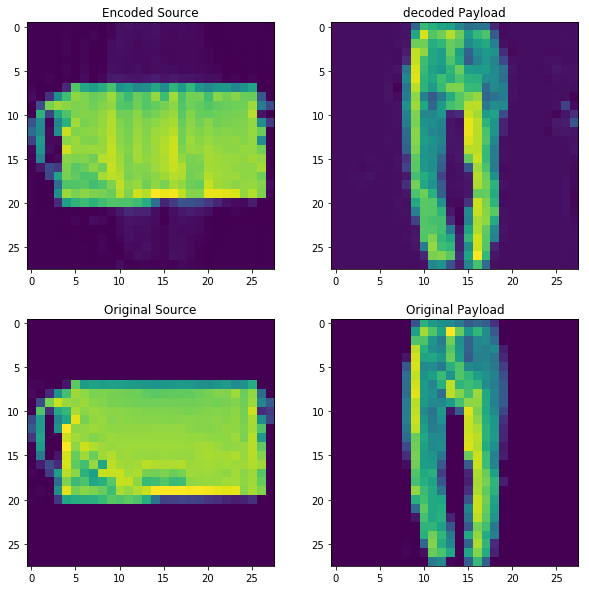

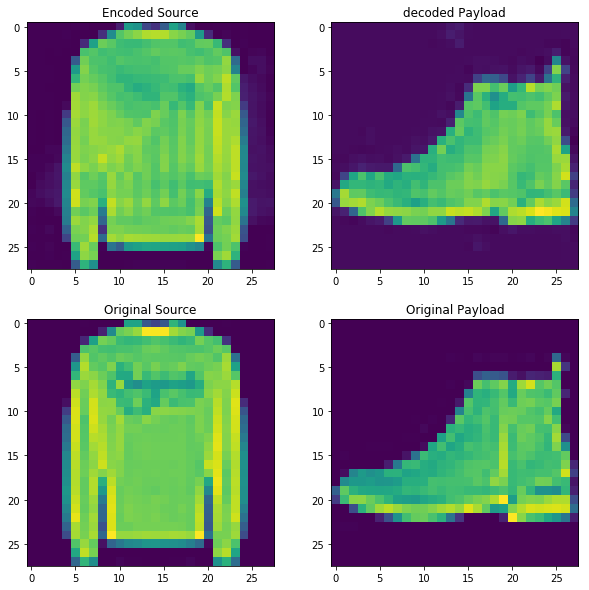

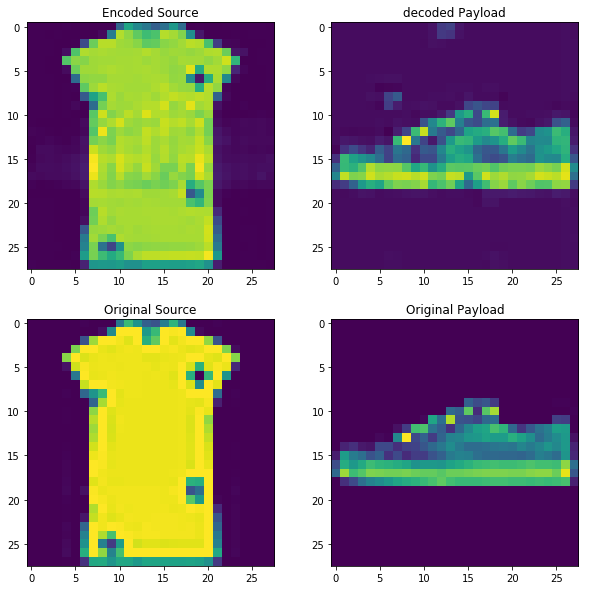

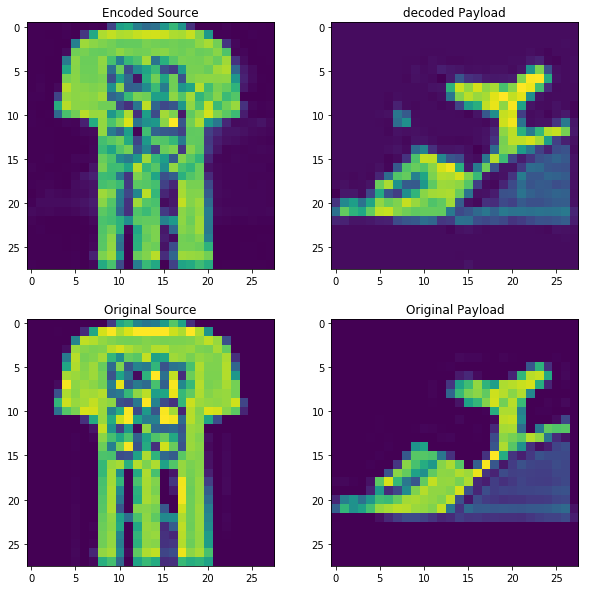

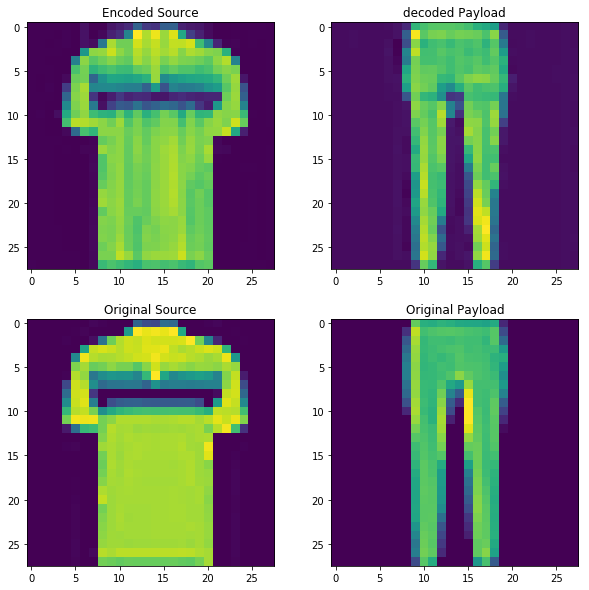

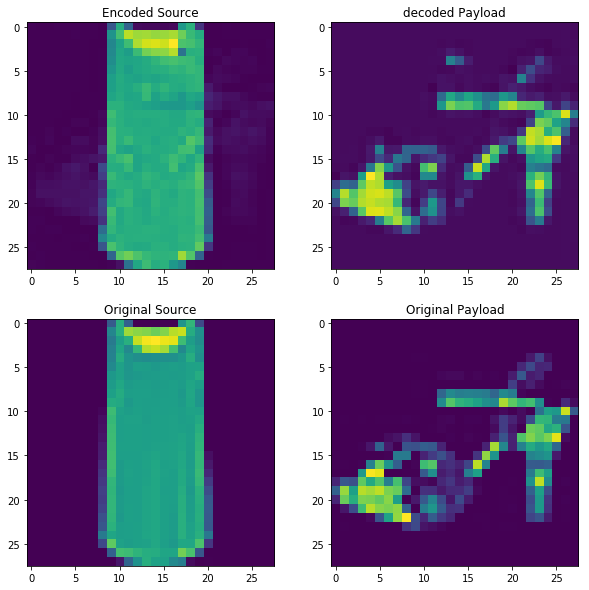

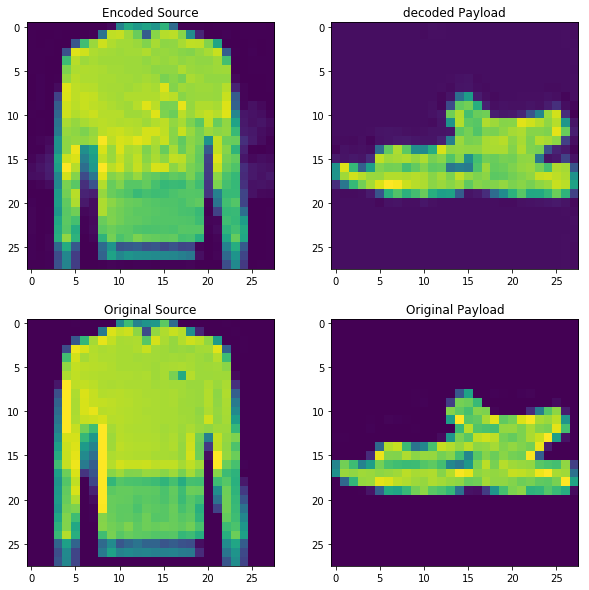

In [62]:
index = 20
for index in range(30):
    eimage = e.numpy().squeeze(1)[index]
    dimage = d.numpy().squeeze(1)[index]

    sourceimage, payloadimage = ss.numpy().squeeze(1)[index], pp.numpy().squeeze(1)[index]
    plt.figure(figsize=(10,10))
    plt.subplot(2, 2, 1)
    plt.title('Encoded Source')
    plt.imshow(eimage)
    plt.subplot(2, 2, 2)
    plt.title('decoded Payload')
    plt.imshow(dimage)

    plt.subplot(2, 2, 3)
    plt.title('Original Source')
    plt.imshow(sourceimage)
    plt.subplot(2, 2, 4)
    plt.title('Original Payload')
    plt.imshow(payloadimage)
    
    plt.show()

In [46]:
p.shape

torch.Size([60, 1, 28, 28])

In [47]:
test_loss = 0.
model.eval()
with torch.no_grad():
    for idx in tqdm(range(int(len(source_val) / 60))):
        s, p = source_test[idx*60: (idx * 60) + 60], payload_test[idx*60: (idx * 60) + 60]
        s, p = torch.from_numpy(s).unsqueeze(1).float().cuda(), torch.from_numpy(p).unsqueeze(1).float().cuda()

        e_out, d_out = model.forward((s, p))

        e_loss = metric(e_out.squeeze(1).view((-1, 28 * 28)), s.squeeze(1).view((-1, 28 * 28)))
        d_loss = metric(d_out.squeeze(1).view((-1, 28 * 28)), p.squeeze(1).view((-1, 28 * 28)))
        loss = e_loss + d_loss

        test_loss += loss

    print('Test Loss: {}'.format(test_loss /int(len(source_test) / 60)))

100%|██████████| 50/50 [00:00<00:00, 335.65it/s]

Test Loss: 15.140098571777344
